# Practical demo of bootstrap process for linear polymer structure building and MD setup from scratch

In [1]:
# Warning suppression and logging
import warnings 
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER

logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)
from IPython.display import clear_output

# Chemistry tools
from enum import Enum, auto
class PortMethod(Enum):
    '''For specifying how ports should be added to a complete RDMol'''
    MAP_NUMBERS   = auto()
    BOND_CLEAVAGE = auto()
    REACTION      = auto() # not included here : provide an MDL rxn template

from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule

from polymerist.rdutils import rdkdraw # configure molecule drawing
rdkdraw.set_rdkdraw_size(400, 3/2)
rdkdraw.disable_substruct_highlights()

# define output directory
from pathlib import Path

outdir = Path('demos')
outdir.mkdir(exist_ok=True)

# 0) Predefining some monomer examples for you to play with

In [2]:
from dataclasses import dataclass, field

@dataclass
class MonomerExample:
    '''For encapsulating info about a base monomer unit'''
    molname : str
    smiles : str
    bond_map_nums : tuple[int, ...]
    isotope_map : dict[int, int] = field(default_factory=dict)
    assign_port_by : PortMethod = field(default=PortMethod.BOND_CLEAVAGE)

# defining some concrete examples
monomer_examples = {
    'PVC' : MonomerExample(
        molname='polyvinylchloride',
        smiles='C=C-Cl',
        bond_map_nums=(1, 2),
        isotope_map={5 : 0, 6 : 0},
        assign_port_by=PortMethod.BOND_CLEAVAGE,
    ),
    'PE' : MonomerExample(
        molname = 'polyethylene',
        smiles = 'C=C',
        bond_map_nums=(1, 2),
        isotope_map = {3 : 0, 4 : 0},
        assign_port_by = PortMethod.BOND_CLEAVAGE
    ),
    'PAAm' : MonomerExample(
        molname = 'polyacrylamide',
        smiles = 'C=CC(=O)N',
        bond_map_nums=(1, 2),
        isotope_map = {7 : 0, 8 : 0},
        assign_port_by = PortMethod.BOND_CLEAVAGE
    ),
    'PS' : MonomerExample(
        molname = 'polystyrene',
        smiles = 'c1ccccc1C=C',
        bond_map_nums = (7, 8),
        isotope_map = {14 : 0, 16 : 0},
        assign_port_by = PortMethod.BOND_CLEAVAGE
    ),
    'Chitosan' : MonomerExample(
        molname = 'polyglucosamine',
        smiles = 'N[C@H]1C(O)OC(CO)[C@@H](O)[C@@H]1O',
        bond_map_nums=(7, 8),
        isotope_map = {17 : 0, 23 : 0},
        assign_port_by = PortMethod.MAP_NUMBERS
    )
}

# 1) Building monomer templates from basic SMILES

## Choose monomer HERE to define SMILES

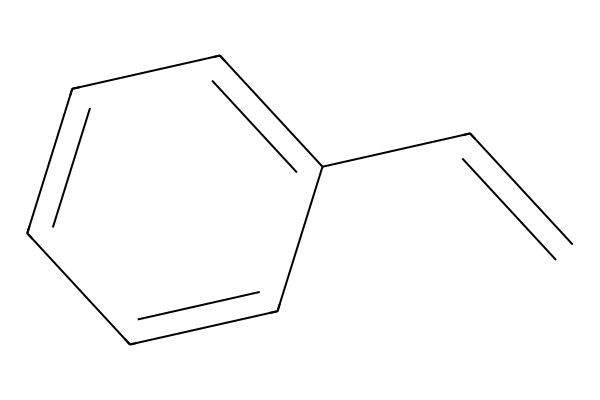

In [3]:
chosen_example = monomer_examples['PS'] # feel at leisure to swap this out for another example
orig_smiles_mol = Chem.MolFromSmiles(chosen_example.smiles, sanitize=False)
display(orig_smiles_mol)

In [4]:
moldir = outdir / chosen_example.molname
moldir.mkdir(exist_ok=True, parents=True)

monodir = moldir / 'monomer_info'
monodir.mkdir(exist_ok=True)

## Expand SMILES to include full chemical info 
Namely, this includes explicit Hs, Kekulized aromatic rings, and atom map numbers

[C:1]1(-[H:9])=[C:2](-[H:10])-[C:3](-[H:11])=[C:4](-[H:12])-[C:5](-[H:13])=[C:6]-1-[C:7](=[C:8](-[H:15])-[H:16])-[H:14]


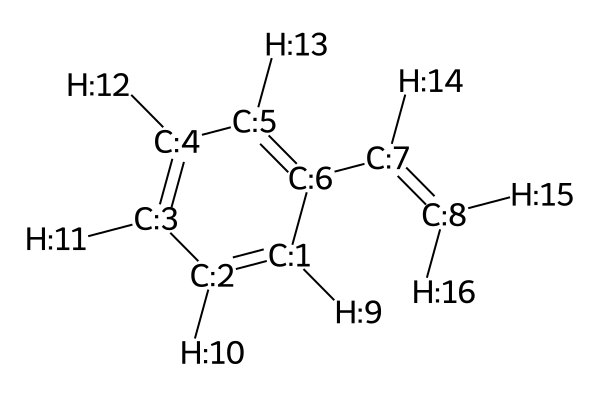

In [5]:
from polymerist.monomers.substruct import specification
from pathlib import Path


new_smiles = specification.expanded_SMILES(chosen_example.smiles)
FULL_SMILES_MOL = Chem.MolFromSmiles(new_smiles, sanitize=False)
print(new_smiles)
display(FULL_SMILES_MOL)

## Assigning linkers for inter-monomer bonds

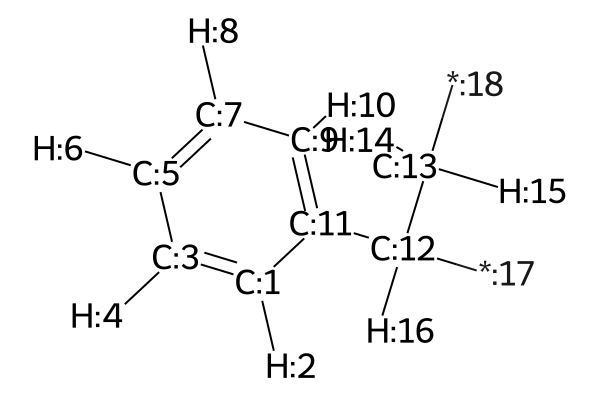

In [6]:
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.amalgamation import portlib, bonding


if portlib.get_num_ports(FULL_SMILES_MOL) == 0: # check for existence of ports to ensure idempotency
    if chosen_example.assign_port_by == PortMethod.MAP_NUMBERS:
        map_nums = chosen_example.isotope_map.keys()
        for (atom_id, map_num) in zip(molwise.atom_ids_by_map_nums(FULL_SMILES_MOL, *map_nums), map_nums):
            linker_atom = FULL_SMILES_MOL.GetAtomWithIdx(atom_id)
            linker_atom.SetIsotope(chosen_example.isotope_map[map_num])
            linker_atom.SetAtomicNum(0)

    elif chosen_example.assign_port_by == PortMethod.BOND_CLEAVAGE:
        rwmol = Chem.RWMol(FULL_SMILES_MOL)
        bond_atom_ids = molwise.atom_ids_by_map_nums(rwmol, *chosen_example.bond_map_nums)
        FULL_SMILES_MOL = bonding.decrease_bond_order(rwmol, *bond_atom_ids)
        molwise.assign_ordered_atom_map_nums(FULL_SMILES_MOL, in_place=True)
        Chem.SanitizeMol(FULL_SMILES_MOL, sanitizeOps=specification.SANITIZE_AS_KEKULE) 

    elif chosen_example.assign_port_by == PortMethod.REACTION:
        raise NotImplemented
    else:
        raise TypeError(f'Must provide a valid port assignment method (cannot be of type {type(chosen_example.assign_port_by)})')

display(FULL_SMILES_MOL)

## Enumerating "cap" groups from linkers and generating spec-compliant SMARTS

In [7]:
from copy import deepcopy
from polymerist.genutils.iteration import subsets


smarts = {}
sat_ids = subsets(portlib.get_linker_ids(FULL_SMILES_MOL), exclude_full=True)
for i, linkers_to_saturate in enumerate(sat_ids):
    new_mono = deepcopy(FULL_SMILES_MOL)
    for linker_id in linkers_to_saturate:
        linker_atom = new_mono.GetAtomWithIdx(linker_id)
        linker_atom.SetAtomicNum(1)
    molwise.assign_ordered_atom_map_nums(new_mono, in_place=True) # renumber with added atoms to preserve order correspondence
    Chem.SanitizeMol(new_mono, sanitizeOps=specification.SANITIZE_AS_KEKULE) # sanitize for good measure, making sure NOT to re-add aromaticity

    key = chosen_example.molname if not i else f'{chosen_example.molname}_TERM{i}'
    smarts[key] = [specification.compliant_mol_SMARTS(Chem.MolToSmiles(new_mono)).replace('#0', '*')] # for some reason, MolToSmarts doesn't reflect hydrogen addition

2023-11-14 13:07:51.582 [WARNING :   specification:line 126 ] - Cleaned 18 SMARTS atom query aberrations introduced by RDKit
2023-11-14 13:07:51.591 [WARNING :   specification:line 126 ] - Cleaned 18 SMARTS atom query aberrations introduced by RDKit
2023-11-14 13:07:51.600 [WARNING :   specification:line 126 ] - Cleaned 18 SMARTS atom query aberrations introduced by RDKit


## Specify orientation of terminal monomers and create monomer representation object

polystyrene


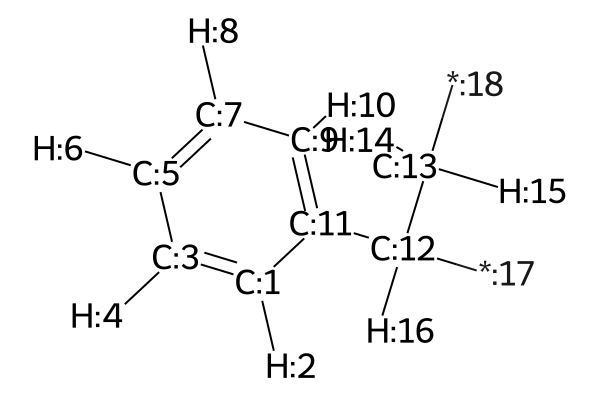

polystyrene_TERM1


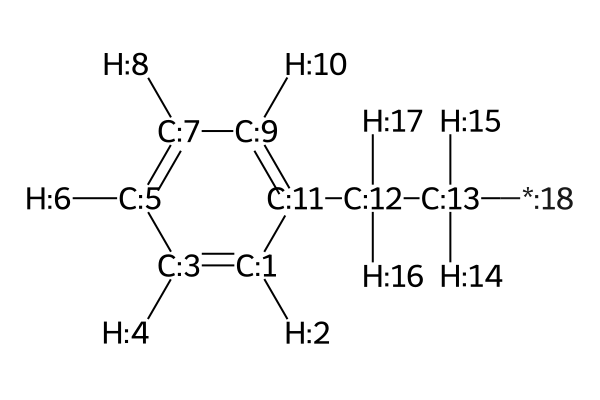

polystyrene_TERM2


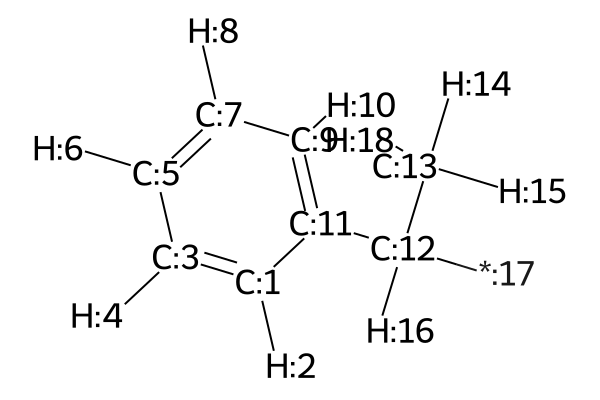

In [8]:
from polymerist.monomers import MonomerGroup
from polymerist.genutils.fileutils.pathutils import assemble_path

grp = MonomerGroup(
    monomers=smarts,
    term_orient={
        f'{chosen_example.molname}_TERM1' : 'head',
        f'{chosen_example.molname}_TERM2' : 'tail',
    }    
)

for (resname, rdmol) in grp.iter_rdmols():
    print(resname)
    display(rdmol)

mono_path = assemble_path(monodir, chosen_example.molname, extension='json')
grp.to_file(mono_path) # cache monomer SMARTS for future use

# 2) Generate coordinates and structure files with chemical info

In [9]:
pdbdir = moldir / 'pdb_structures'
pdbdir.mkdir(exist_ok=True)

sdfdir = moldir / 'sdf_structures'
sdfdir.mkdir(exist_ok=True)

## Grow chain of arbitrary DOP and generate PDB (only linear polymers currently supported)

In [10]:
from polymerist.polymers import building, estimation

DOP = 50

chain = building.build_linear_polymer(grp, DOP=DOP, energy_minimize=True)
pdb_path = assemble_path(pdbdir, chosen_example.molname, extension='pdb')
building.mbmol_to_openmm_pdb(pdb_path, chain)
chain.visualize(backend='nglview')

2023-11-14 13:07:52.058 [INFO    :        building:line 78  ] - Using pre-defined terminal group orientation {'polystyrene_TERM1': 'head', 'polystyrene_TERM2': 'tail'}
2023-11-14 13:07:52.060 [INFO    :        building:line 89  ] - Registering middle monomer polystyrene (block identifier "A")
2023-11-14 13:07:52.116 [INFO    :        building:line 99  ] - Registering terminal monomer polystyrene_TERM1 (orientation "head")
2023-11-14 13:07:52.134 [INFO    :        building:line 99  ] - Registering terminal monomer polystyrene_TERM2 (orientation "tail")
2023-11-14 13:07:52.152 [INFO    :        building:line 106 ] - Assembling linear polymer chain with 50 monomers (802 atoms)
2023-11-14 13:07:52.484 [INFO    :        building:line 110 ] - Successfully assembled linear polymer chain with 50 monomers (802 atoms)
2023-11-14 13:07:52.485 [INFO    :        building:line 113 ] - Energy-minimizing chain to find more stabile conformer
2023-11-14 13:09:16.560 [INFO    :        building:line 115 ]

NGLWidget()

## Fill in missing PDB chemical info with our OpenFF substructure match tools
Subsequently, partition into distinct residues and save to info-rich SDF format to avoid duplication of effort

In [11]:
from openff.toolkit import Topology, Molecule
from polymerist.openfftools import topology
from polymerist.residues.partition import partition


# load PDB with substructure cover; if successful, refine into partition
offtop = Topology.from_pdb(pdb_path, _custom_substructures=grp.monomers)
was_partitioned = partition(offtop)
assert(was_partitioned)

# extract Molecule for Topology, set name and replace
offmol = topology.get_largest_offmol(offtop)
offmol.name = chosen_example.molname
offtop = offmol.to_topology()
display(offmol)

# serialize Topology to SDF to preserve fully-specified system
top_path = assemble_path(sdfdir, chosen_example.molname, extension='sdf')
topology.topology_to_sdf(top_path, offtop) 

NGLWidget()

2023-11-14 13:09:18.834 [INFO    :        topology:line 89  ] - Successfully serialized SDF Topology to demos/polystyrene/sdf_structures/polystyrene.sdf


## Repeat the above steps with atom cap to provide structure for RCT demo

In [12]:
redux_DOP = estimation.estimate_DOP_supremum(grp, max_chain_len=100)

redux_chain = building.build_linear_polymer(grp, DOP=redux_DOP, energy_minimize=True)
redux_pdb_path = assemble_path(pdbdir, chosen_example.molname, postfix='redux', extension='pdb')
building.mbmol_to_openmm_pdb(redux_pdb_path, redux_chain)
redux_chain.visualize(backend='nglview')

2023-11-14 13:09:18.903 [INFO    :        building:line 78  ] - Using pre-defined terminal group orientation {'polystyrene_TERM1': 'head', 'polystyrene_TERM2': 'tail'}
2023-11-14 13:09:18.904 [INFO    :        building:line 89  ] - Registering middle monomer polystyrene (block identifier "A")
2023-11-14 13:09:18.943 [INFO    :        building:line 99  ] - Registering terminal monomer polystyrene_TERM1 (orientation "head")
2023-11-14 13:09:18.968 [INFO    :        building:line 99  ] - Registering terminal monomer polystyrene_TERM2 (orientation "tail")
2023-11-14 13:09:18.989 [INFO    :        building:line 106 ] - Assembling linear polymer chain with 6 monomers (98 atoms)
2023-11-14 13:09:19.010 [INFO    :        building:line 110 ] - Successfully assembled linear polymer chain with 6 monomers (98 atoms)
2023-11-14 13:09:19.011 [INFO    :        building:line 113 ] - Energy-minimizing chain to find more stabile conformer
2023-11-14 13:09:20.687 [INFO    :        building:line 115 ] - E

NGLWidget()

In [13]:
redux_offtop = Topology.from_pdb(redux_pdb_path, _custom_substructures=grp.monomers)
was_partitioned = partition(redux_offtop)
assert(was_partitioned)

redux_offmol = topology.get_largest_offmol(redux_offtop)
redux_offmol.name = chosen_example.molname
redux_offtop = redux_offmol.to_topology()
display(redux_offmol)

redux_top_path = assemble_path(sdfdir, chosen_example.molname, postfix='redux', extension='sdf')
topology.topology_to_sdf(redux_top_path, redux_offtop) # preserve fully-specified system in SDF format

NGLWidget()

2023-11-14 13:09:22.173 [INFO    :        topology:line 89  ] - Successfully serialized SDF Topology to demos/polystyrene/sdf_structures/polystyrene_redux.sdf


# 3) Assignment of atomic partial charges

## Espaloma assignment (fast and direct)

In [14]:
from polymerist.openfftools import pcharge

charge_method = 'Espaloma-AM1-BCC'
charger = pcharge.MolCharger.subclass_registry[charge_method]()
espmol = charger.charge_molecule(offmol) # inherits name from base molecule

espmol_path = assemble_path(sdfdir, chosen_example.molname, postfix=charge_method, extension='sdf')
topology.topology_to_sdf(espmol_path, espmol.to_topology())

2023-11-14 13:09:22.303 [INFO    :         pcharge:line 34  ] - Assigning partial charges via the "Espaloma-AM1-BCC" method
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name 'polystyrene' and SMILES '[H]c1c(c(c(c(c1[H])[H])[C@]([H])([C@@]([H])(c2c(c(c(c(c2[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c3c(c(c(c(c3[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c4c(c(c(c(c4[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c5c(c(c(c(c5[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c6c(c(c(c(c6[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c7c(c(c(c(c7[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c8c(c(c(c(c8[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c9c(c(c(c(c9[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c1c(c(c(c(c1[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c1c(c(c(c(c1[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c1c(c(c(c(c1[H])[H])[H])[H])[H])C([H])([H])[C@@]([H])(c1c(c(c(c(c1[H])[H])[H])[H])[H])C([H])([H

## RCT (reliable and provides charge templates)

### Perform explicit AM1-BCC-ELF10 (requires OpenEye on reduced-size polymer (THIS WILL TAKE A WHILE!)
Luckily, only needs to be done once per molecule

In [15]:
charge_method = 'AM1-BCC-ELF10'
abe10_charger = pcharge.MolCharger.subclass_registry[charge_method]()
abe10mol = abe10_charger.charge_molecule(redux_offmol)

2023-11-14 13:09:24.991 [INFO    :         pcharge:line 34  ] - Assigning partial charges via the "AM1-BCC-ELF10" method
2023-11-14 13:14:05.350 [INFO    :         pcharge:line 37  ] - Successfully assigned "AM1-BCC-ELF10" charges


### Extract and save library charges, apply these to the target macromolecule (look how quick *this part* it is!)

In [16]:
from polymerist.residues.rescharge.calculation import compute_residue_charges
from polymerist.residues.rescharge.interface import LibraryCharger


lib_chgs = compute_residue_charges(abe10mol, grp)
lib_chg_path = assemble_path(monodir, chosen_example.molname, postfix='library_charges', extension='json')
lib_chgs.to_file(lib_chg_path) # save library charges for future use

lib_charger = LibraryCharger(lib_chgs)
rctmol = lib_charger.charge_molecule(offmol)
rctmol_path = assemble_path(sdfdir, chosen_example.molname, postfix='RCT', extension='sdf')
topology.topology_to_sdf(rctmol_path, rctmol.to_topology())

2023-11-14 13:14:05.630 [INFO    :     calculation:line 32  ] - Selected representative residue groups
2023-11-14 13:14:05.633 [INFO    :     calculation:line 60  ] - Accumulated charges across all matching residues
2023-11-14 13:14:05.634 [INFO    :     calculation:line 70  ] - Redistributing charges for residue "polystyrene" according to UniformDistributionStrategy
2023-11-14 13:14:05.636 [INFO    :     calculation:line 70  ] - Redistributing charges for residue "polystyrene_TERM1" according to UniformDistributionStrategy
2023-11-14 13:14:05.637 [INFO    :     calculation:line 70  ] - Redistributing charges for residue "polystyrene_TERM2" according to UniformDistributionStrategy
2023-11-14 13:14:05.639 [INFO    :     calculation:line 75  ] - Successfully computed library charges for Molecule "polystyrene"
2023-11-14 13:14:05.697 [INFO    :         pcharge:line 34  ] - Assigning partial charges via the "RCT" method
2023-11-14 13:14:05.701 [INFO    :     calculation:line 88  ] - Succes

# 4) Assign FF parameters and running simulations with OpenMM

In [17]:
ommdir = moldir / 'openmm'
ommdir.mkdir(exist_ok=True)

## Defining periodic box

In [18]:
import numpy as np
from openmm.unit import gram, centimeter, nanometer
from polymerist.openfftools.solvation import boxvectors

top_path = espmol_path # choose path to desired parameterized & charged topology
# top_path = rctmol_path
offtop = topology.topology_from_sdf(top_path, allow_undefined_stereo=True)

exclusion = 1 * nanometer # how far beyond the tight bounding box of the polymer to extend the periodic box

# box_dims = np.array([4.0, 4.0, 4.0]) * nanometer
box_dims = boxvectors.get_topology_bbox(offtop)
box_vecs = boxvectors.box_vectors_flexible(box_dims)
box_vecs = boxvectors.pad_box_vectors_uniform(box_vecs, exclusion)
clear_output() # clear verbose stereochemistry warnings if present

## Packing box with solvent

In [19]:
from polymerist.openfftools.solvation import solvents 
from polymerist.openfftools.solvation.packing import pack_topology_with_solvent

solvent = solvents.water_TIP3P
rho = 0.997 * gram / centimeter**3

solv_top = pack_topology_with_solvent(offtop, solvent=solvent, box_vecs=box_vecs, density=rho, exclusion=exclusion)
solv_path = assemble_path(sdfdir, top_path.stem, postfix=f'solv_{solvent.name}', extension='sdf')
topology.topology_to_sdf(solv_path, solv_top)

2023-11-14 13:14:06.904 [INFO    :         packing:line 35  ] - Solvating 144.24056503511432 nm**3 Topology with 4808 water_TIP3P molecules to density of 0.997 g/(cm**3)
2023-11-14 13:14:13.149 [INFO    :         packing:line 44  ] - Packmol packing converged
2023-11-14 13:14:13.151 [INFO    :         packing:line 47  ] - Set solvated Topology box vectors to [[7.8193999290466305 0.0 0.0] [0.0 3.4291000366210938 0.0] [0.0 0.0 5.379399943351745]] nanometer
2023-11-14 13:14:18.650 [INFO    :        topology:line 89  ] - Successfully serialized SDF Topology to demos/polystyrene/sdf_structures/polystyrene_Espaloma-AM1-BCC_solv_water_TIP3P.sdf


## Generate OpenMM files and run simulations

In [20]:
from polymerist.openmmtools.parameters import SimulationParameters
from polymerist.openfftools.omminter import openff_topology_to_openmm
from polymerist.openmmtools.execution import run_simulation_schedule

ff_name = 'openff-2.0.0'
sim_params_path = Path('sample_sim_params.json')

sim_params = SimulationParameters.from_file(sim_params_path)
print(sim_params.thermo_params)
print(sim_params.integ_params)
print(sim_params.reporter_params)
schedule = {
    'demo' : sim_params
}

ommtop, ommsys, ommpos = openff_topology_to_openmm(solv_top, forcefield=ff_name, box_vecs=box_vecs)
history = run_simulation_schedule(ommdir, schedule, ommtop, ommsys, ommpos, return_history=True)

ThermoParameters(ensemble='NVT', temperature=Quantity(value=300, unit=kelvin), pressure=Quantity(value=1, unit=atmosphere), friction_coeff=Quantity(value=1, unit=/picosecond), barostat_freq=100)
IntegratorParameters(time_step=Quantity(value=2, unit=femtosecond), total_time=Quantity(value=100, unit=picosecond), num_samples=50)
ReporterParameters(report_checkpoint=True, report_state=True, report_trajectory=True, report_state_data=True, traj_ext='dcd', num_steps=50000, state_data={'step': True, 'time': True, 'potentialEnergy': True, 'kineticEnergy': True, 'totalEnergy': True, 'temperature': True, 'volume': True, 'density': True, 'speed': True, 'progress': False, 'remainingTime': False, 'elapsedTime': False}, reporter_paths=None)


2023-11-14 13:14:19.338 [INFO    :      parameters:line 2993] - Attempting to up-convert Electrostatics section from 0.3 to 0.4
2023-11-14 13:14:19.339 [INFO    :      parameters:line 3003] - Successfully up-converted Electrostatics section from 0.3 to 0.4. `method="PME"` is now split into `periodic_potential="Ewald3D-ConductingBoundary"`, `nonperiodic_potential="Coulomb"`, and `exception_potential="Coulomb"`.
2023-11-14 13:14:46.018 [INFO    :       execution:line 38  ] - Initializing simulation 1/1 ("demo")
2023-11-14 13:14:46.020 [INFO    :          thermo:line 83  ] - Created LangevinMiddleIntegrator for NVT (Canonical) ensemble
2023-11-14 13:14:48.074 [INFO    :       reporters:line 127 ] - Prepared DCDReporter which reports to demos/polystyrene/openmm/demo/demo_trajectory.dcd
2023-11-14 13:14:48.075 [INFO    :       reporters:line 127 ] - Prepared CheckpointReporter which reports to demos/polystyrene/openmm/demo/demo_checkpoint.chk
2023-11-14 13:14:48.076 [INFO    :       reporte